In [2]:
import numpy as np
import h5py
import netCDF4 as nc
import os
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.ensemble
from sklearn import metrics
import seaborn as sns
sns.set_theme()

In [3]:
fp2 = h5py.File('data/QAQC_0.25.h5','r')
fp5 = h5py.File('data/QAQC_0.5.h5','r')
fp1 = h5py.File('data/QAQC_1.h5','r')

In [450]:
fp1.close()

In [4]:
def getEB(fp):
    EB_ = fp['NETRAD'][:]-fp['H'][:]-fp['LE'][:]-fp['G'][:]
    EB_pct_= EB_/fp['NETRAD'][:]
    return EB_,EB_pct_

In [252]:
def getangle(fp,dx):
    u=fp['U'][:]
    v=fp['V'][:]
    xgrad=fp['LST_'+str(dx)+'_XGRAD'][:]
    ygrad=fp['LST_'+str(dx)+'_YGRAD'][:]
    xgrada=fp['LST_'+str(dx)+'_XGRAD_ABS'][:]
    ygrada=fp['LST_'+str(dx)+'_YGRAD_ABS'][:]
    xgradn=xgrad/np.sqrt(xgrad**2+ygrad**2)
    ygradn=ygrad/np.sqrt(ygrad**2+xgrad**2)
    un=u/np.sqrt(u**2+v**2)
    vn=v/np.sqrt(u**2+v**2)
    dot=[]
    for i in range(len(u)):
        dot.append(np.dot([u[i],v[i]],[xgradn[i],ygradn[i]]))
    alpha= np.arccos(dot)/(np.sqrt(un**2+vn**2)+np.sqrt(xgradn**2+ygradn**2))
    alpha[alpha>np.pi]=float('nan')
    alpha=np.degrees(alpha)
    alpha[alpha>90]=180-alpha[alpha>90]
    
    # now with abs
    dot=[]
    for i in range(len(u)):
        dot.append(np.dot([u[i],v[i]],[xgrada[i],ygrada[i]]))
    alphaa= np.arccos(dot)/(np.sqrt(u**2+v**2)+np.sqrt(xgrada**2+ygrada**2))
    alphaa[alphaa>np.pi]=float('nan')
    alphaa=np.degrees(alphaa)
    alphaa[alphaa>90]=180-alphaa[alphaa>90]
    return alpha,alphaa

In [253]:
alph1,alph1a = getangle(fp1,1)
alph2,alph2a = getangle(fp2,0.25)
alph5,alph5a = getangle(fp5,0.5)

/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in arccos
  from ipykernel import kernelapp as app
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in arccos
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-p

(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025]),
 <a list of 6 Text yticklabel objects>)

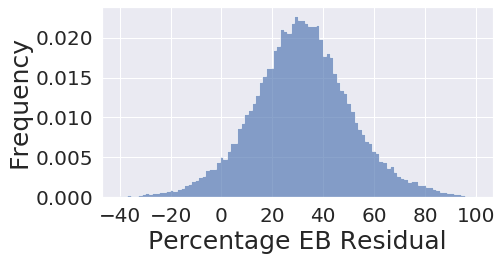

In [233]:
plt.figure(figsize=(7,3.5))
EB_=getEB(fp1)[1]
m=(fp1['qH2O'][:]==0)
m=m&(EB_<1)
m=m&(EB_>-.4)
#m=m&(np.abs(EB_)<1000)
#m=m&(doy>100)&(doy<200)
m=m&(fp1['NETRAD'][:]>300)
m=m&(fp1['ZL'][:]<0)
EB_plt=EB_[m]
plt.hist(EB_plt*100,bins=100,density=True,histtype='stepfilled',alpha=.65)
plt.xlabel('Percentage EB Residual',fontsize=25)
plt.ylabel('Frequency',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [202]:
EB_=getEB(fp1)[0]
m=(fp1['qH2O'][:]==0)
#m=m&(EB_<1)
#m=m&(EB_>-.4)
m=m&(np.abs(EB_)<1000)
#m=m&(doy>100)&(doy<200)
m=m&(fp1['NETRAD'][:]>300)
m=m&(fp1['ZL'][:]<0)
EB_plt=EB_[m]

In [203]:
m2=m&(hod>0)
ebh=np.zeros((int(np.max(hod[m2]*2))+1,))
cnth=np.zeros((int(np.max(hod[m2]*2))+1,))
for i in range(len(hod[m2])):
    h=hod[m2][i]
    hdx=int(h*2)
    ebh[hdx]=ebh[hdx]+EB_[m2][i]
    cnth[hdx]=cnth[hdx]+1

In [204]:
EB_out=ebh/(cnth+1)
EB_out[cnth<10]=float('nan')

35

In [205]:
a=np.linspace(0,np.max(hod[m2]),int(np.max(hod[m2]))*2+1)

(array([ 60.,  80., 100., 120., 140., 160., 180.]),
 <a list of 7 Text yticklabel objects>)

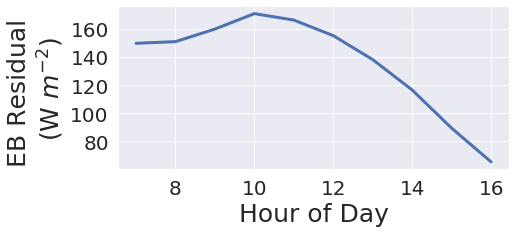

In [234]:
plt.figure(figsize=(7,3))
plt.plot(a[0:-1:2],EB_out[0:-1:2],linewidth=3)
plt.xlabel('Hour of Day',fontsize=25)
plt.ylabel('EB Residual \n(W $m^{-2}$)',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [68]:
std=fp1['LST_1_STD'][:]#/(fp1['LST_1_MEAN'][:]-273)

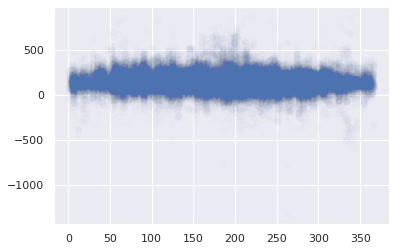

In [178]:
plt.scatter(doy[m2],EB_[m2],alpha=.01)

(array([10718.,  7134.,     0., 22263.,     0.,     0., 40573.,     0.,
            0., 35385.]),
 array([-8. , -7.7, -7.4, -7.1, -6.8, -6.5, -6.2, -5.9, -5.6, -5.3, -5. ]),
 <a list of 10 Patch objects>)

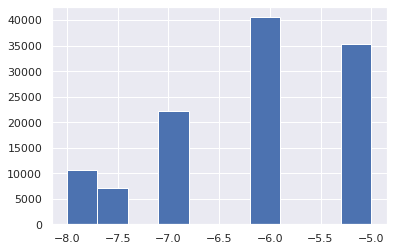

In [127]:
plt.hist(utcoff)

In [44]:
def plot_xEB(x,EB_,a_,w_,alim=0,wlim=9999):
    m=~np.isnan(a_)&~np.isnan(x)
    m=m&(a_>alim)
    m=m&(w_<wlim)
    m=m&(EB_<500)
    x=x[m]
    EB_=EB_[m]
    plt.hexbin(x,EB_,mincnt=1,cmap='terrain',gridsize=40,extent=(np.percentile(x,0.5),np.percentile(x,99.5),np.percentile(EB_,0.5),np.percentile(EB_,99.5)))
    return stats.spearmanr(x,EB_)[0]

SpearmanrResult(correlation=-0.3343263655217332, pvalue=3.383861692691393e-185)


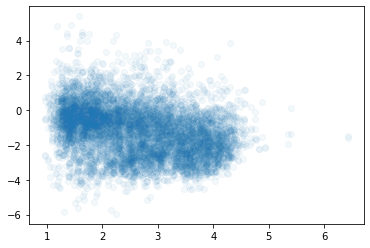

In [184]:
m=fp1['site'][:]==b'SRER'
m=m&(fp1['ZL'][:]<0)
plt.scatter(fp1['LST_1_STD'][:][m],np.log(-fp1['ZL'][:][m]),alpha=.05)
#plt.xscale('log')
r=stats.spearmanr(np.log(-fp1['ZL'][:][m]),fp1['LST_1_STD'][:][m])
print(r)

In [303]:
from mpl_toolkits import mplot3d

-0.2213185465238869

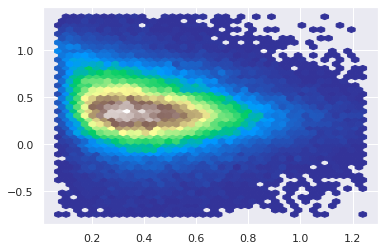

In [298]:
std=fp1['LST_1_STD'][:]
grad=np.sqrt(fp1['LST_1_XGRAD'][:]**2+fp1['LST_1_YGRAD'][:]**2)
plot_xEB(fp1['USTAR'][:],(getEB(fp1)[1]),alph1,fp1['WS'][:],0)

(0, 1)

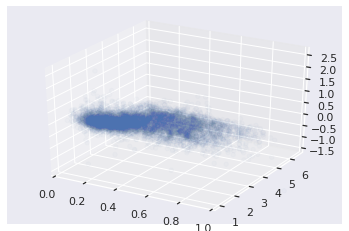

In [309]:
fig = plt.figure()
m=fpsites==b'SRER'
ax = fig.add_subplot(projection='3d')
ax.scatter(fp1['USTAR'][m],fp1['LST_1_STD'][m],getEB(fp1)[1][m],alpha=0.02)
plt.xlim(0,1)


In [24]:
import datetime

In [283]:
doy=[]
hod=[]
lstd=np.zeros((len(fpsites),))
dt= datetime.datetime(1970,1,1,0,0)
dayold=dt.date()
siteold='asdf'
times=fp1['TIME'][:]
stds=fp1['LST_1_STD'][:]
ilist=[]
lsts=[]
utcoff=fp1['utc_off'][:]
for i in range(len(fp1['TIME'][:])):
    t=times[i]
    dtt=dt+datetime.timedelta(seconds=t)
    doy.append(dtt.timetuple().tm_yday)
    hod.append(dtt.hour+utcoff[i])
    if (siteold!=fpsites[i]) or (dayold!=dtt.date()):
        lstd[ilist]=np.mean(lsts)
        lsts=[]
        ilist=[]
    ilist.append(i)
    lsts.append(stds[i])
    dayold=dtt.date()
    siteold=fpsites[i]
doy=np.array(doy)
hod=np.array(hod)
hod[hod<=0]=24+hod[hod<=0]

/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [129]:
hod[hod<=0]=24+hod[hod<=0]

In [287]:
import matplotlib as mpl
from sklearn import linear_model

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 8.00000e+00, 6.73500e+03,
        1.09009e+05, 3.09000e+02, 8.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([-3.85696195, -3.05062717, -2.24429239, -1.4379576 , -0.63162282,
         0.17471197,  0.98104675,  1.78738153,  2.59371632,  3.4000511 ,
         4.20638588]),
 <a list of 10 Patch objects>)

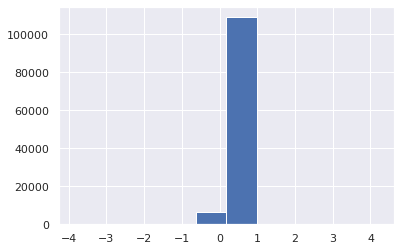

In [452]:
plt.hist(fp1['EBDp'][:])

/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


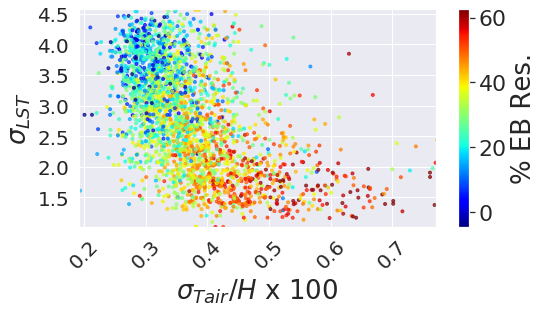

In [346]:

rs=[]
sites2=[b'SRER']
std=fp1['LST_1_STD'][:]#/(fp1['LST_1_MEAN'][:]-273)
for site in sites2:
    fig,ax=plt.subplots(figsize=(8,4))
    m=fpsites==site
    m=m&(fp1['NETRAD'][:]>300)
    m=m&(fp1['G'][:]<200)
    m=m&(fp1['ZL'][:]<0)
    m=m&(bowen>0)&(bowen<20)
    m=m&(fp1['qH2O'][:]==0)
    EB_=getEB(fp1)[1][m]*100
    color=plt.cm.jet((EB_-np.percentile(EB_,1))/(np.percentile(EB_,99)-np.percentile(EB_,1)))
    #ustr=np.array(doy)[m]
    ustr=fp1['T_SONIC_SIGMA'][m]/fp1['H'][m]*100
    lstr=std[m]#fp1['LST_1_STD'][m]/(fp1['LST_1_MEAN'][m]-273)
    plt.scatter(ustr,lstr,color=color,s=9,alpha=.7)
    plt.xlim(np.percentile(ustr,.1),np.percentile(ustr,99.5))
    plt.ylim(np.percentile(lstr,.1),np.percentile(lstr,99.5))
    plt.xlabel('$\sigma_{Tair}/H$ x 100',fontsize=26)
    plt.ylabel('$\sigma_{LST}$',fontsize=26)
    try:
        regr = linear_model.LinearRegression()
        regr.fit(np.array([ustr,lstr]).T, EB_)
        scr=regr.score(np.array([ustr,lstr]).T, EB_)
    except:
        scr=0
    rs.append(scr)
    #plt.title(str(site)+' '+str(scr))
    plt.xticks(fontsize=20,rotation=45)
    plt.yticks(fontsize=20)
    cmap = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=np.percentile(EB_,1), vmax=np.percentile(EB_,99))
    cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
    cbar.set_label('% EB Res.',fontsize=26)
    cbar.ax.tick_params(labelsize=22)

(array([13., 12.,  6.,  4.,  0.,  2.,  1.,  0.,  0.,  1.]),
 array([1.54603016e-04, 3.15407255e-02, 6.29268481e-02, 9.43129706e-02,
        1.25699093e-01, 1.57085216e-01, 1.88471338e-01, 2.19857461e-01,
        2.51243583e-01, 2.82629706e-01, 3.14015828e-01]),
 <a list of 10 Patch objects>)

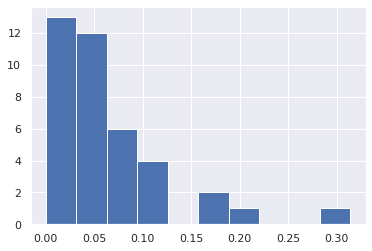

In [433]:
plt.hist(rs)

In [434]:
print(np.mean(rs))

0.06372582264709326


In [22]:
sites=[]
fpsites=fp1['site'][:]
for site in fpsites:
    if site not in sites:
        sites.append(site)
sites.sort()
sites=np.array(sites)

In [284]:
def plot_xEB(x,EB_,a_,w_,alim=0,wlim=9999):
    m=~np.isnan(a_)&~np.isnan(x)
    m=m&(a_>alim)
    m=m&(w_<wlim)
    m=m&(EB_<500)
    x=x[m]
    EB_=EB_[m]
    plt.hexbin(x,EB_,mincnt=1,cmap='terrain',gridsize=40,extent=(np.percentile(x,0.5),np.percentile(x,99.5),np.percentile(EB_,0.5),np.percentile(EB_,99.5)))
    return stats.spearmanr(x,EB_)[0]

In [285]:
rs=[]
bowen=fp1['H'][:]/fp1['LE'][:]
std=fp1['LST_1_STD'][:]/(fp1['LST_1_MEAN'][:]-273)
sites2=[b'SRER']
for site in sites2:
    plt.figure()
    m=fp1sites==site
    m=m&(bowen>0)&(bowen<20)
    m=m&(fp1['qH2O'][:]==0)
    #m=m&(doy>100)&(doy<200)
    m=m&(fp1['NETRAD'][:]>300)
    m=m&(fp1['ZL'][:]<0)
    m=m&(hod==16)
    EB=(getEB(fp1)[1])[m]#/(fp1['H'][m]+fp1['LE'][m])
    #var=fp1['T_SONIC_SIGMA'][m]/fp1['H'][m]#np.log(-fp1['ZL'][m])#fp1['WS'][m]
    #var=fp1['H'][m]
    var=std[m]
    r=plot_xEB(var,EB,alph1[m],fp1['WS'][:][m],0)
    rs.append(r)
    plt.title(str(site)+' '+str(r))
plt.figure()
plt.hist(rs)

/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


IndexError: cannot do a non-empty take from an empty axes.

<Figure size 432x288 with 0 Axes>

In [580]:
np.mean(rs)

-0.40583763938539597

(array([4., 4., 6., 4., 6., 7., 6., 2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 <a list of 8 Patch objects>)

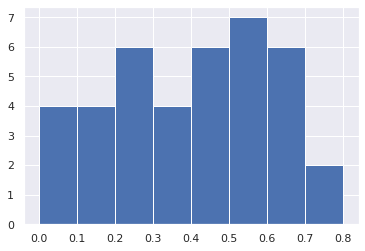

In [574]:
plt.hist(rs,bins=[0,.1,.2,.3,.4,.5,.6,.7,.8])

Text(0.5, 1.0, 'TSSH')

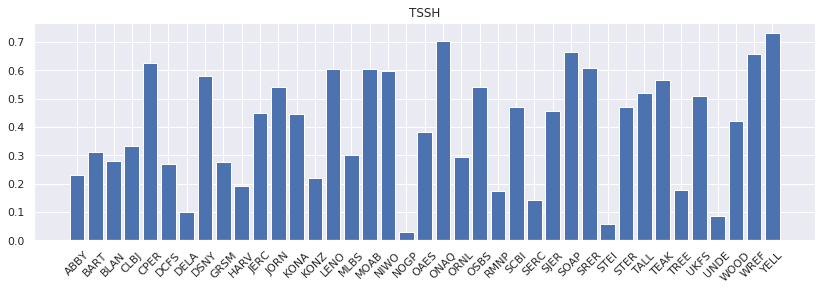

In [577]:
plt.figure(figsize=(14,4))
plt.bar(sites,rs)
plt.xticks(rotation=45)
plt.title('TSSH')

In [493]:
pred=['CD','H2O','TA','WS','ZL','NETRAD','USTAR','ANGLE','BOWEN','LST_1_STD']
pred=['H2O','TA','NETRAD','BOWEN','LST_1_MEAN','WS','USTAR','T_SONIC_SIGMA','LST_1_STD']
bowen=fp1['H'][:]/fp1['LE'][:]
m=~np.isnan(alph1)
m=m&(fp1['ZL'][:]<0)
m=m&~np.isnan(bowen)
m=m&(bowen<50)
m=m&(bowen>0)
n = len(fp1['H'][m])
n2 = len(pred)
result=getEB(fp1)[1][m]

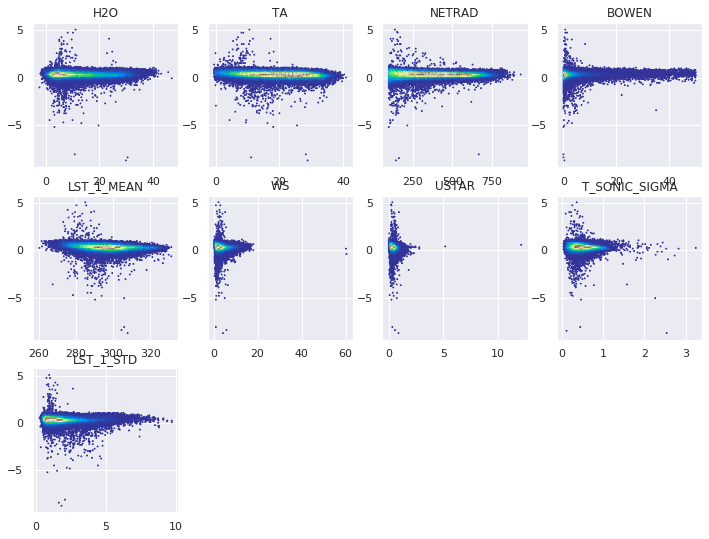

In [494]:
data=np.zeros((n2,n))
i = 0
fig = plt.figure(figsize=(12,9))
for x in pred:
    if x == 'ANGLE':
        data[i,:]=alph1[m]
    elif x == 'BOWEN':
        data[i,:]=bowen[m]
    elif x == 'GRAD':
        data[i,:]=grad[m]
    else:
        data[i,:]=fp1[x][m]
    plt.subplot(3,4,i+1)
    try:
        plt.hexbin(data[i,:],result,gridsize=150,cmap='terrain',mincnt=1,extent=(mins[x],maxs[x],rmin,rmax))
    except Exception:
        plt.hexbin(data[i,:],result,gridsize=150,cmap='terrain',mincnt=1)
    plt.title(x,fontsize=12)
    #plt.xlabel(xlabels[x],fontsize=10)
    #plt.title(names[x]+' '+xlabels[x],fontsize=12)
    i = i+1
#fig.suptitle('Direct Comparison of Environmental Covariates vs $\sigma_T$',fontsize=20)
data = np.transpose(data)

In [495]:
X_train, X_test, y_train, y_test = train_test_split(data,result, test_size=0.2, random_state=0)

# Run RF
clf = sklearn.ensemble.RandomForestRegressor(random_state=1,n_estimators=100,oob_score=True)
clf.fit(X_train,y_train)

RandomForestRegressor(oob_score=True, random_state=1)

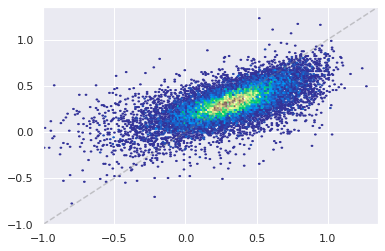

In [498]:
y_pred = clf.predict(X_test)
plt.figure()
minn=min(np.min(y_test2),np.min(y_pred))
minn=-1
maxx=max(np.max(y_test2),np.max(y_pred))
plt.hexbin(y_test,y_pred,cmap='terrain',gridsize=200,mincnt=1,extent=(minn,maxx,minn,maxx))
plt.plot([minn,maxx],[minn,maxx],'--',color='grey',alpha=.4)

In [499]:
print(clf.oob_score_)

0.34676472857295126


Bias: -0.0028806514761931575
Normalized RMSE: 0.7130672138535437
OOB Score: 0.43165302784820225


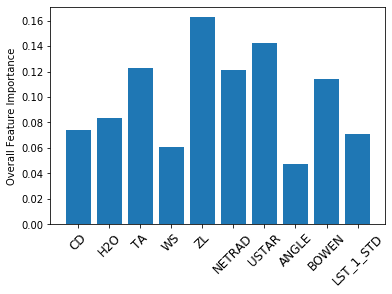

In [222]:
fIMP = clf.feature_importances_
plt.bar(pred,fIMP)
#plt.title("RF Feature Importance")
#plt.xlabel("Predictor")
plt.ylabel("Overall Feature Importance")
plt.xticks(rotation=45,fontsize=12)
#plt.grid(False,axis='x')
bias = np.sum(y_pred-y_test)/len(y_pred)
print('Bias: '+str(bias/np.mean(y_test)))
print('Normalized RMSE: '+str(metrics.mean_squared_error(y_test, y_pred,squared=False)/np.mean(y_test)))
print('OOB Score: '+ str(clf.oob_score_))

In [488]:
grad=np.sqrt(fp1['LST_1_XGRAD'][:]**2+fp1['LST_1_YGRAD'][:]**2)
pred=['H2O','TA','NETRAD','BOWEN','LST_1_MEAN','WS','USTAR','T_SONIC_SIGMA','LST_1_STD']
fpsites=fp1['site'][:]

b'ABBY'...setup...1264...fitted...predictted...plotted
b'BART'...setup...1271...fitted...predictted...plotted
b'BLAN'...setup...1228...fitted...predictted...plotted
b'CLBJ'...setup...3331...fitted...predictted...plotted
b'CPER'...setup...1734...fitted...predictted...plotted
b'DCFS'...setup...2033...fitted...predictted...plotted
b'DELA'...setup...1708...fitted...predictted...plotted
b'DSNY'...setup...2542...fitted...predictted...plotted
b'GRSM'...setup...1011...fitted...predictted...plotted
b'HARV'...setup...1240...fitted...predictted...plotted
b'JERC'...setup...3048...fitted...predictted...plotted
b'JORN'...setup...6174...fitted...predictted...plotted
b'KONA'...setup...3074...fitted...predictted...plotted
b'KONZ'...setup...3528...fitted...predictted...plotted
b'LENO'...setup...1185...fitted...predictted...plotted
b'MLBS'...setup...1244...fitted...predictted...plotted
b'MOAB'...setup...1475...fitted...predictted...plotted
b'NIWO'...setup...444...fitted...predictted...plotted
b'NOGP'...s

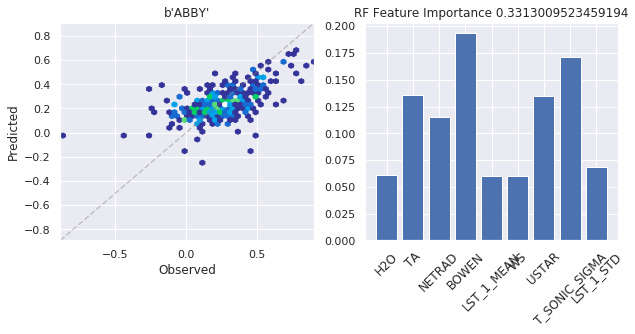

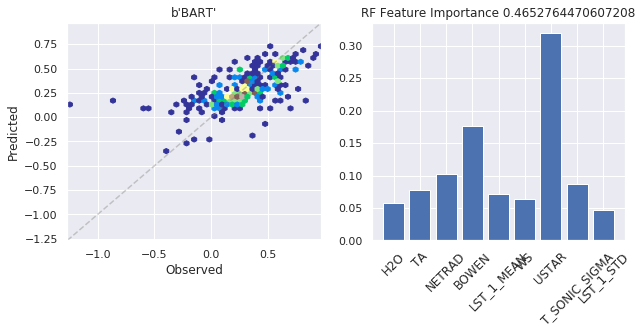

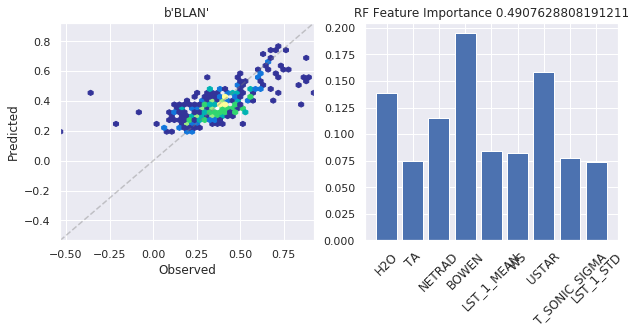

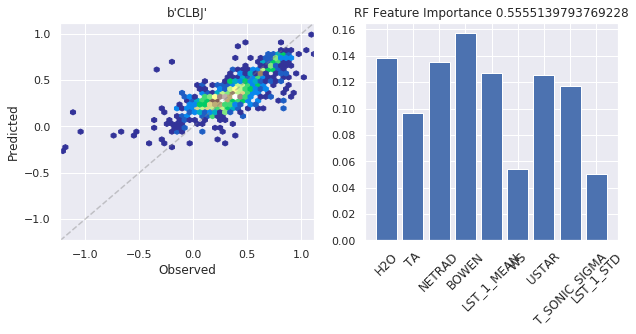

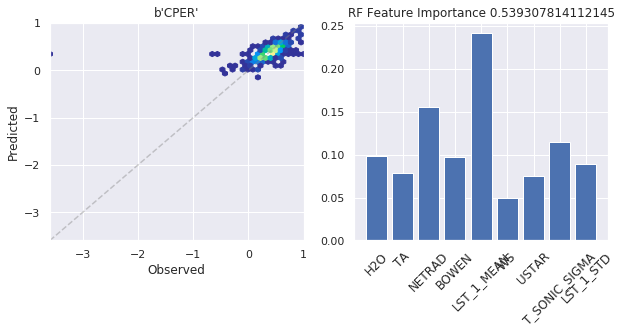

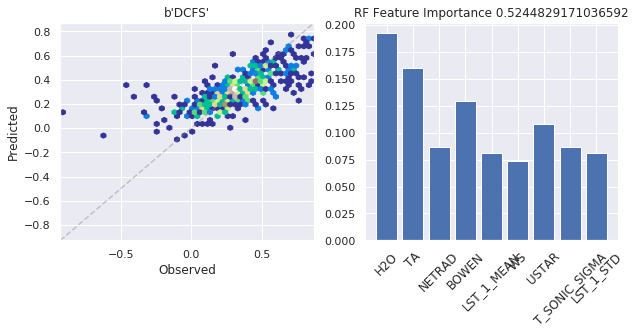

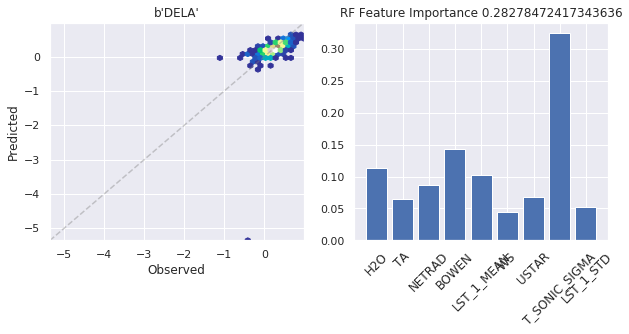

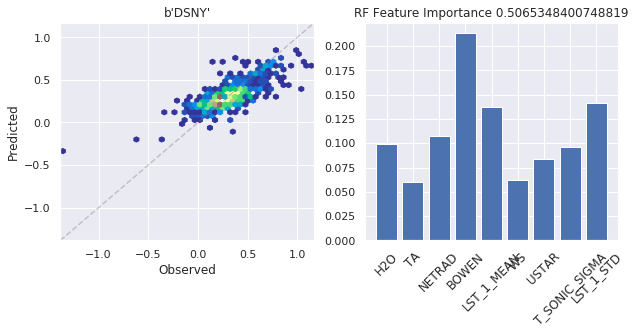

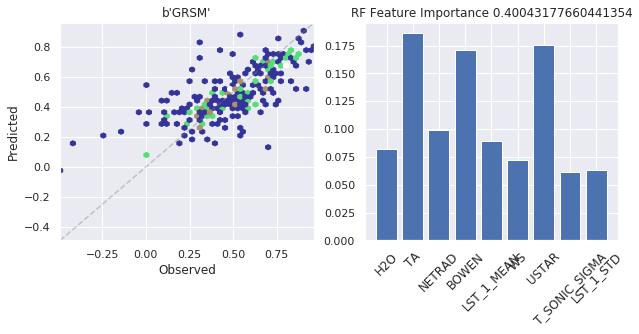

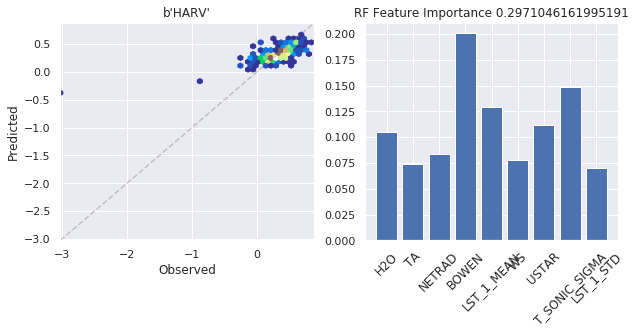

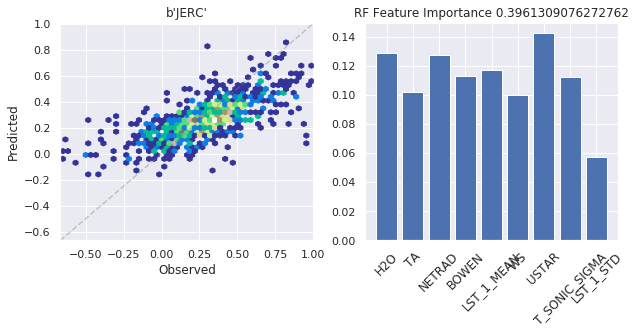

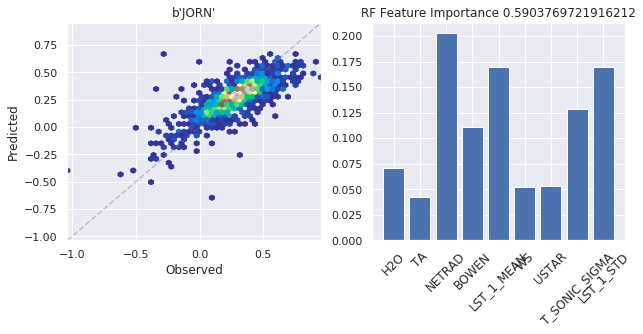

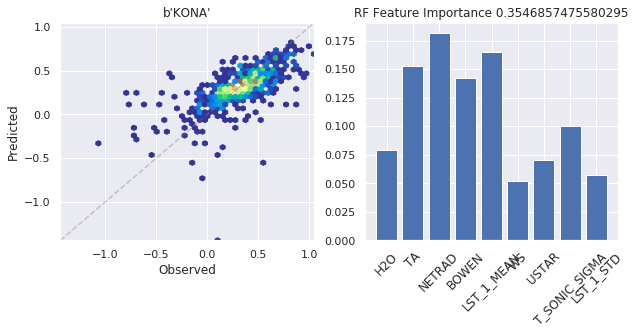

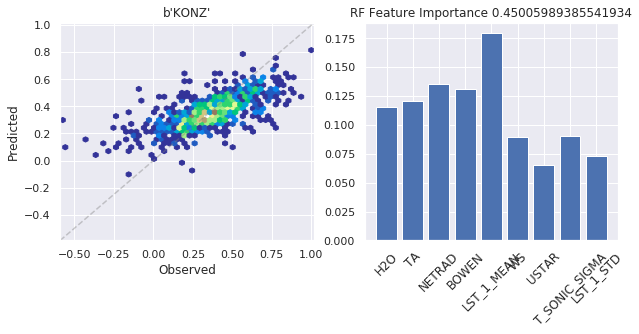

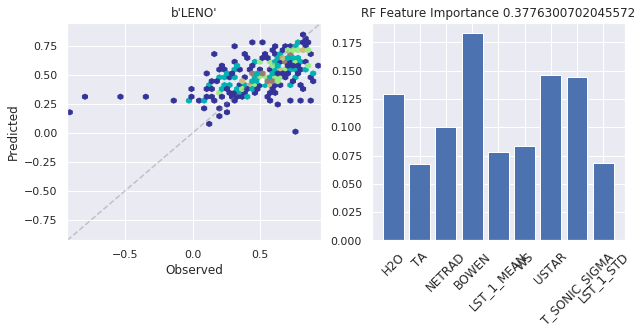

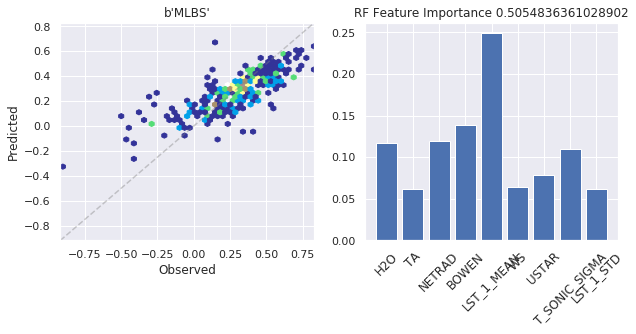

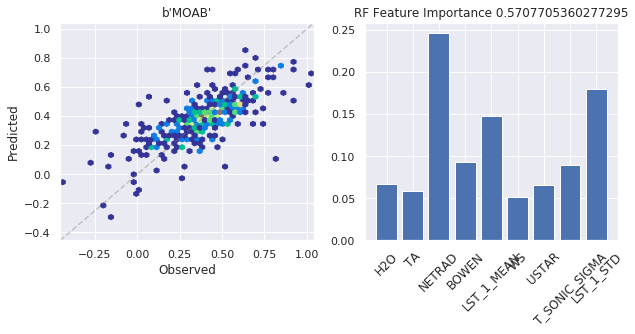

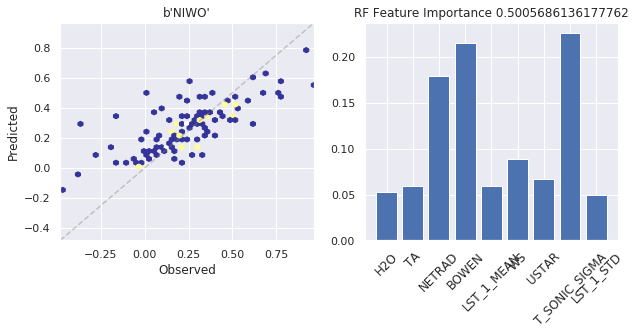

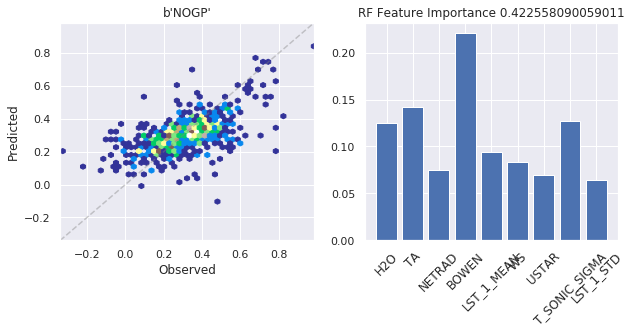

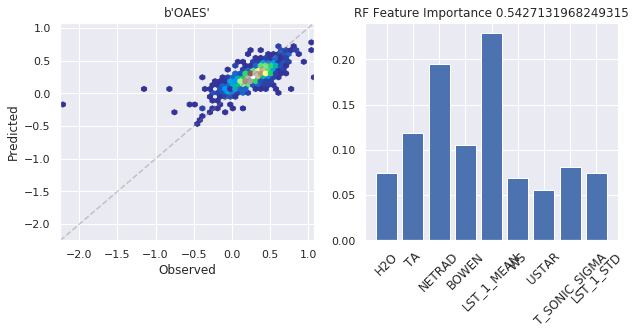

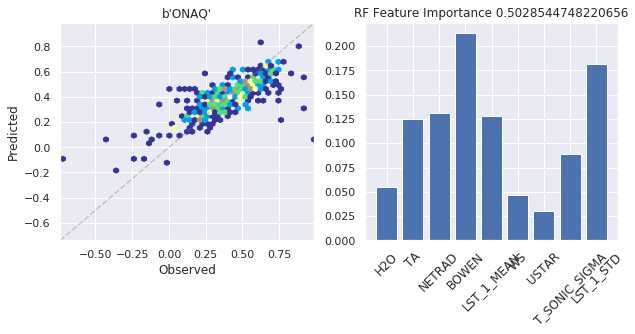

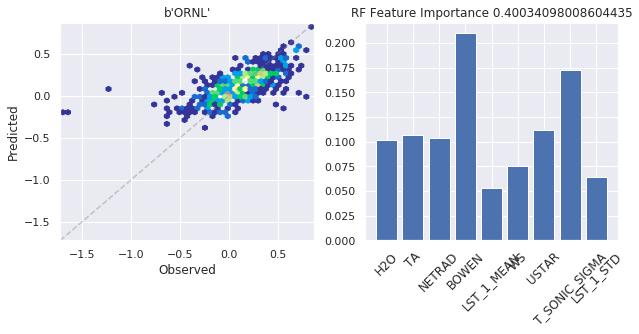

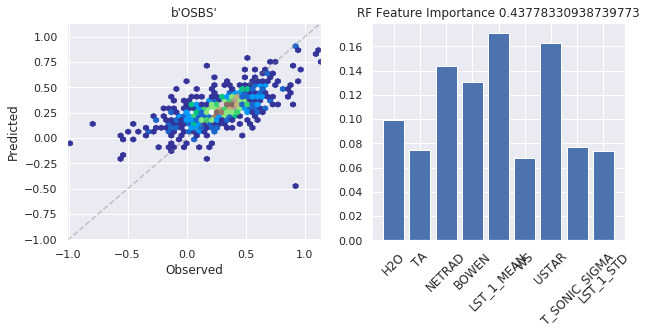

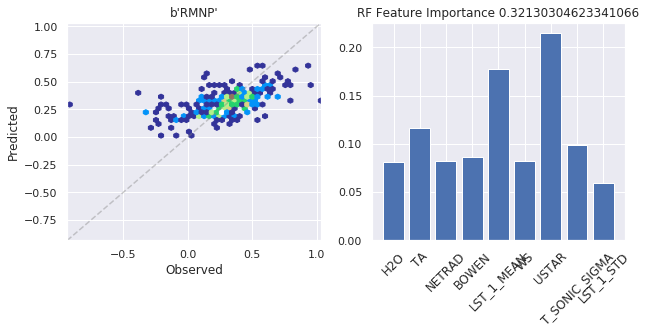

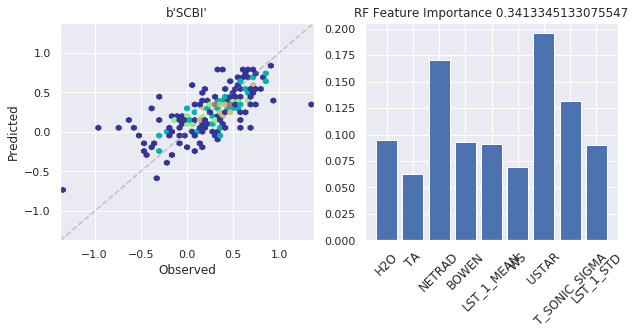

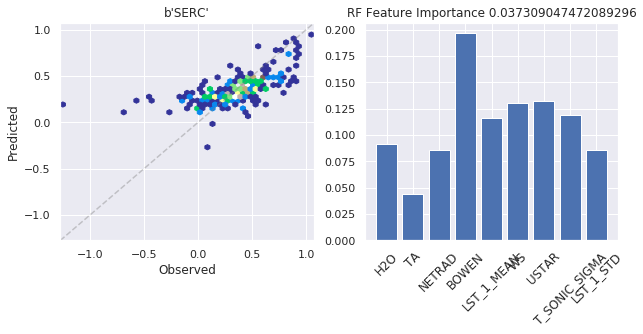

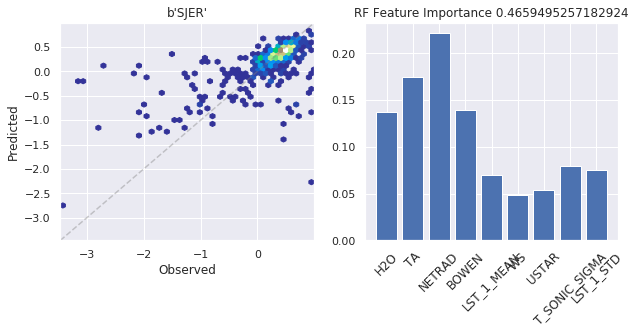

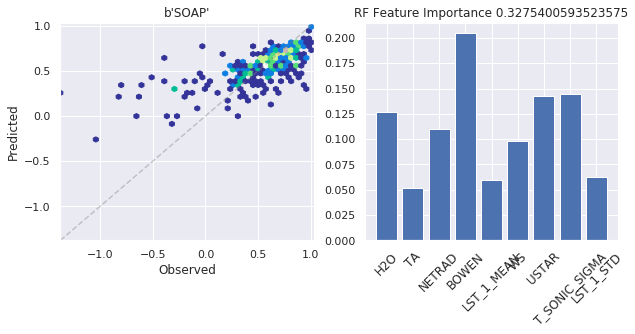

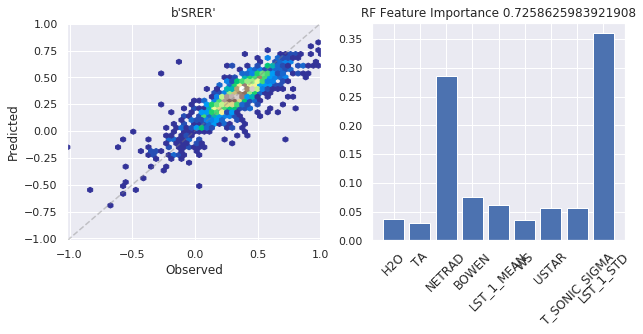

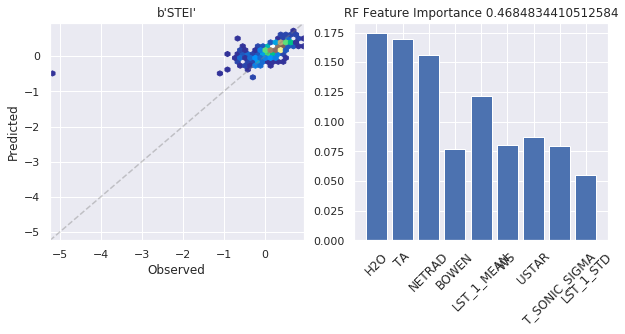

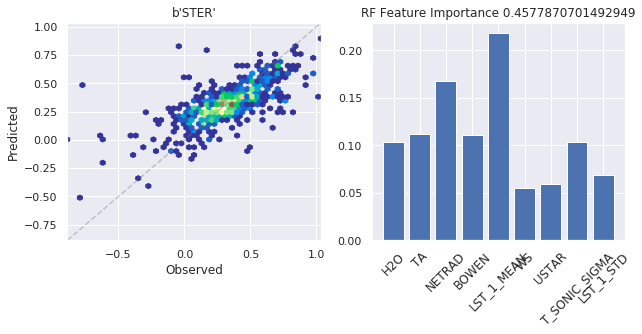

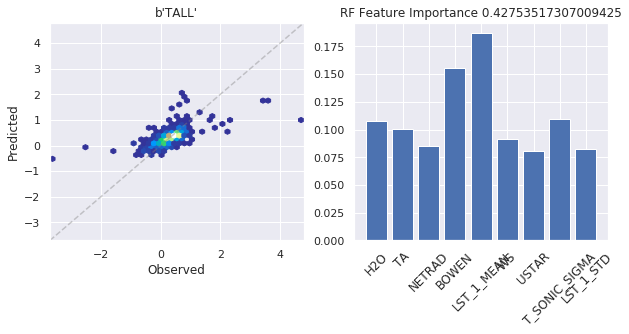

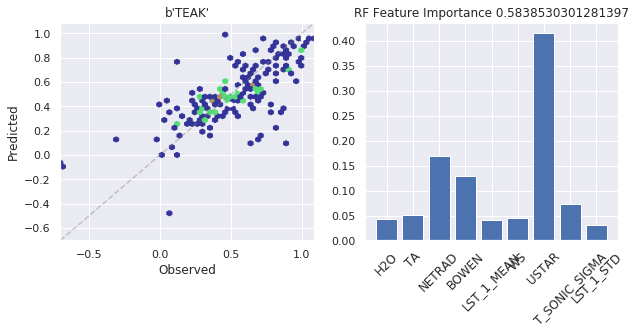

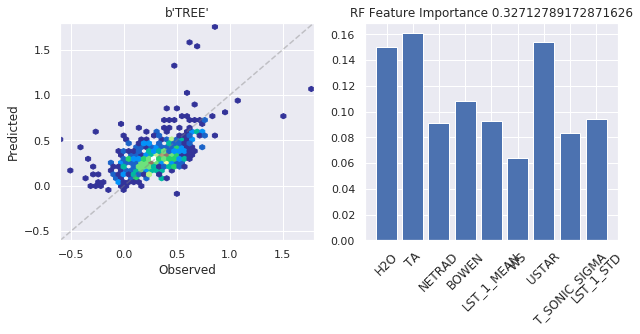

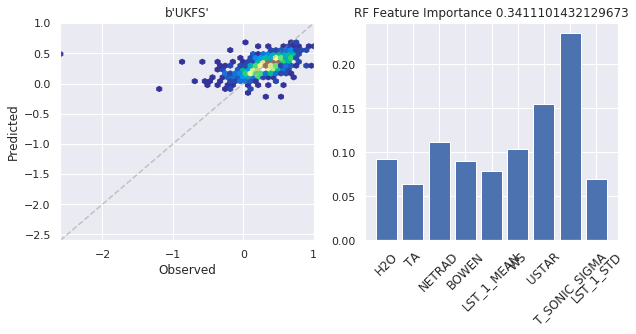

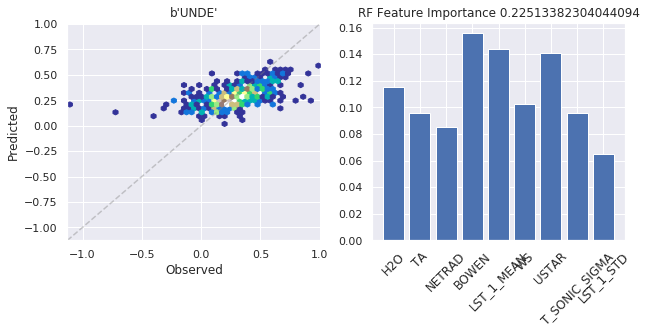

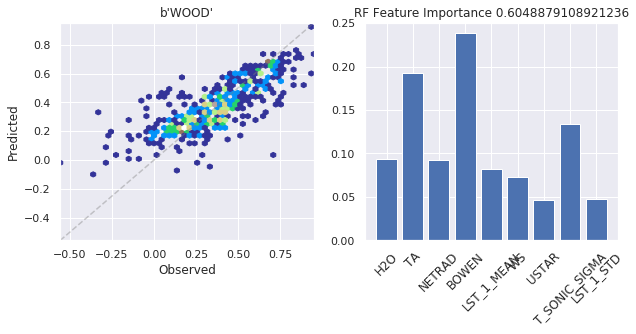

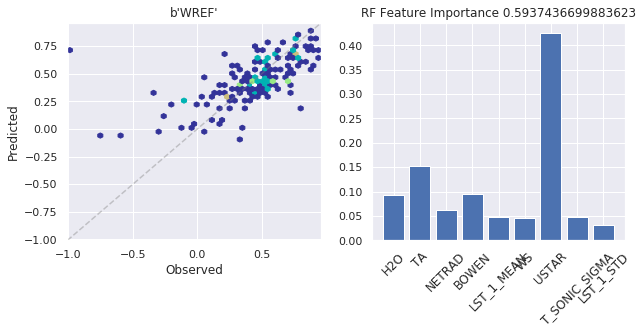

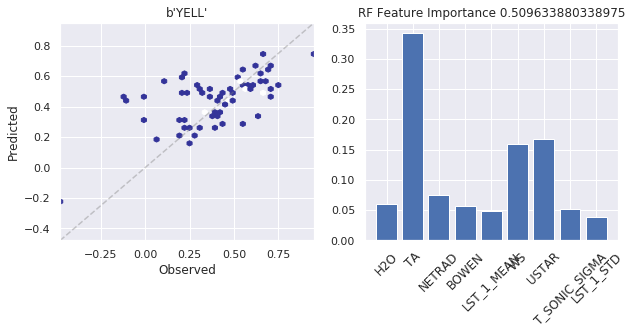

In [489]:
#### SITE BY SITE RF ####
import warnings
warnings.filterwarnings('ignore')
fimps={}
oobs={}
for site in sites:
    print(str(site)+'...',end='')
    m=fp1['site'][:]==site
    m=m&~np.isnan(alph1)
    m=m&(fp1['ZL'][:]<0)
    m=m&~np.isnan(bowen)
    m=m&(bowen<50)
    m=m&(bowen>0)
    n = len(fp1['H'][m])
    n2 = len(pred)
    result=getEB(fp1)[1][m]
    data=np.zeros((n2,n))
    i = 0
    for x in pred:
        if x == 'ANGLE':
            data[i,:]=alph1[m]
        elif x == 'BOWEN':
            data[i,:]=bowen[m]
        elif x == 'GRAD':
            data[i,:]=grad[m]
        else:
            data[i,:]=fp1[x][m]
        i=i+1
    #fig.suptitle('Direct Comparison of Environmental Covariates vs $\sigma_T$',fontsize=20)
    data = np.transpose(data)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(data,result, test_size=0.2, random_state=0)

    # Run RF
    clf2 = sklearn.ensemble.RandomForestRegressor(random_state=1,n_estimators=100,oob_score=True)
    print('setup...'+str(len(y_train2))+'...',flush=True,end='')
    clf2.fit(X_train2,y_train2)
    print('fitted...',flush=True,end='')
    y_pred = clf2.predict(X_test2)
    print('predictted...',flush=True,end='')
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    minn=min(np.min(y_test2),np.min(y_pred))
    maxx=max(np.max(y_test2),np.max(y_pred))
    plt.hexbin(y_test2,y_pred,cmap='terrain',gridsize=50,mincnt=1,extent=(minn,maxx,minn,maxx))
    plt.title(site)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.plot([minn,maxx],[minn,maxx],'--',color='grey',alpha=.4)
    fIMP = clf2.feature_importances_
    fimps[site]=fIMP
    plt.subplot(1,2,2)
    plt.bar(pred,fIMP)
    oobs[site]=clf2.oob_score_
    plt.title("RF Feature Importance "+str(clf2.oob_score_))
    plt.xticks(rotation=45,fontsize=12)
    print('plotted',flush=True)

In [503]:
np.mean(np.array(list(oobs.values())))

0.4411295435977374

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

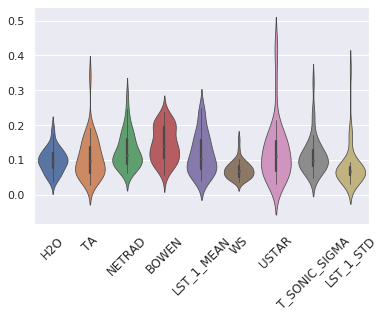

In [490]:
plot_values=np.zeros((len(pred),len(sites)))
for i in range(len(pred)):
    for j in range(len(sites)):
        plot_values[i,j]=fimps[sites[j]][i]
plt.figure(figsize=(6,4))
ax=sns.violinplot(data=plot_values.transpose(),scale='width',linewidth=.75)
ax.set_xticklabels(pred)
plt.xticks(rotation=45,fontsize=12)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

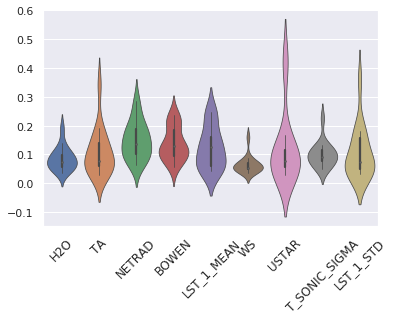

In [491]:
goodsite=[]
for site in sites:
    if oobs[site]<.5:
        continue
    else:
        goodsite.append(site)
plot_values=np.zeros((len(pred),len(goodsite)))
for i in range(len(pred)):
    for j in range(len(goodsite)):
        plot_values[i,j]=fimps[goodsite[j]][i]
plt.figure(figsize=(6,4))
ax=sns.violinplot(data=plot_values.transpose(),scale='width',linewidth=.75)
ax.set_xticklabels(pred)
plt.xticks(rotation=45,fontsize=12)

In [492]:
print(len(goodsite))

15


(0, 600)

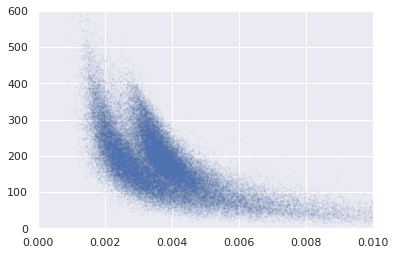

In [571]:
m=~np.isnan(alph1)
m=m&(fp1['ZL'][:]<0)
m=m&~np.isnan(bowen)
m=m&(fp1['NETRAD'][:]>300)
m=m&(bowen<50)
m=m&(bowen>0)
m=m&~np.isnan(fp1['LST_1_CL20'][:])
plt.scatter(fp1['T_SONIC_SIGMA'][m]/fp1['H'][m],fp1['H'][m],s=1,alpha=.05)
plt.xlim(0,.01)
plt.ylim(0,600)

/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


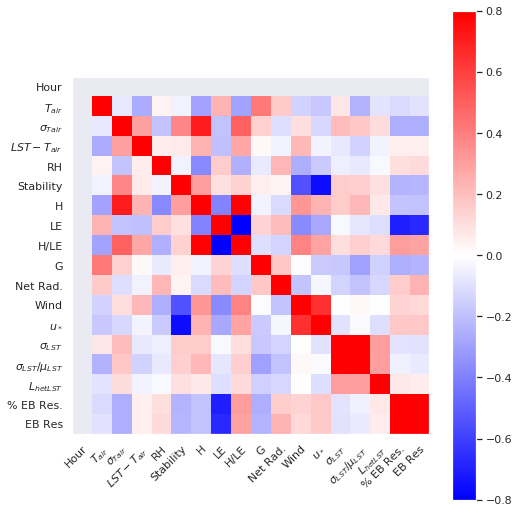

In [278]:
#### CORRELATION MATRIX ####
vars_cm=['HOD','TA','T_SONIC_SIGMA','DELT','RH','logZL','H','LE','BOWEN','G','NETRAD','WS','USTAR','LST_1_STD','COV','LST_1_CL20','EBp','EB']
vars_nm=['Hour','$T_{air}$','$\sigma_{Tair}$','$LST-T_{air}$','RH','Stability','H','LE','H/LE','G','Net Rad.','Wind','$u_*$','$\sigma_{LST}$','$\sigma_{LST}/\mu_{LST}$','$L_{het LST}$','% EB Res.','EB Res']
bowen=fp1['H'][:]/fp1['LE'][:]
m=~np.isnan(alph1)
m=m&(fp1['ZL'][:]<0)
m=m&~np.isnan(bowen)
m=m&(fp1['NETRAD'][:]>300)
m=m&(bowen<50)
m=m&(bowen>0)
m=m&(hod==16)
m=m&~np.isnan(fp1['LST_1_CL20'][:])
datacm=np.zeros((len(vars_cm),len(vars_cm)))
for v in range(len(vars_cm)):
    var1=vars_cm[v]
    if var1 == 'ANGLE':
        dvar1=alph1[m]
    elif var1=='TSSH':
        dvar1=fp1['T_SONIC_SIGMA'][m]/fp1['H'][m]
    elif var1=='COV':
        dvar1=fp1['LST_1_STD'][m]/(fp1['LST_1_MEAN'][m]-273)
    elif var1 == 'BOWEN':
        dvar1=bowen[m]
    elif var1 == 'GRAD':
        dvar1=grad[m]
    elif var1 == 'logZL':
        dvar1=np.log(-fp1['ZL'][m])
    elif var1 == 'EBp':
        dvar1=getEB(fp1)[1][m]
    elif var1 == 'EB':
        dvar1=getEB(fp1)[0][m]
    elif var1 == 'DOY':
        dvar1=doy[m]
    elif var1 == 'DELT':
        dvar1=fp1['LST_1_MEAN'][m]-(fp1['TA'][m]+273)
    elif var1 == 'HOD':
        dvar1=hod[m]
    else:
        dvar1=fp1[var1][m]
    for v2 in range(len(vars_cm)):
        var2=vars_cm[v2]
        if var2 == 'ANGLE':
            dvar2=alph1[m]
        elif var2=='COV':
            dvar2=fp1['LST_1_STD'][m]/(fp1['LST_1_MEAN'][m]-273)
        elif var2 == 'BOWEN':
            dvar2=bowen[m]
        elif var2 == 'GRAD':
            dvar2=grad[m]
        elif var2 == 'logZL':
            dvar2=np.log(-fp1['ZL'][m])
        elif var2== 'EBp':
            dvar2=getEB(fp1)[1][m]
        elif var2 == 'EB':
            dvar2=getEB(fp1)[0][m]
        elif var2 == 'DOY':
            dvar2=doy[m]
        elif var2=='TSSH':
            dvar2=fp1['T_SONIC_SIGMA'][m]/fp1['H'][m]
        elif var2 == 'DELT':
            dvar2=fp1['LST_1_MEAN'][m]-(fp1['TA'][m]+273)
        elif var2 == 'HOD':
            dvar2=hod[m]
        else:
            dvar2=fp1[var2][m]
        
        datacm[v,v2]=stats.spearmanr(dvar1,dvar2)[0]
fig, ax = plt.subplots(figsize=(8,9))
#datacm[np.abs(datacm)>=.9999]=float('nan')
im = ax.imshow(datacm,cmap='bwr',vmin=-.8,vmax=.8)
#im = ax.imshow(np.abs(datacm),cmap='jet',vmin=0,vmax=1)
plt.colorbar(im)
plt.grid(False)
ax.set_yticks(np.arange(len(vars_cm)))
ax.set_yticklabels(vars_nm)
ax.set_xticks(np.arange(len(vars_cm)))
ax.set_xticklabels(vars_nm)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
     rotation_mode="anchor")
print()

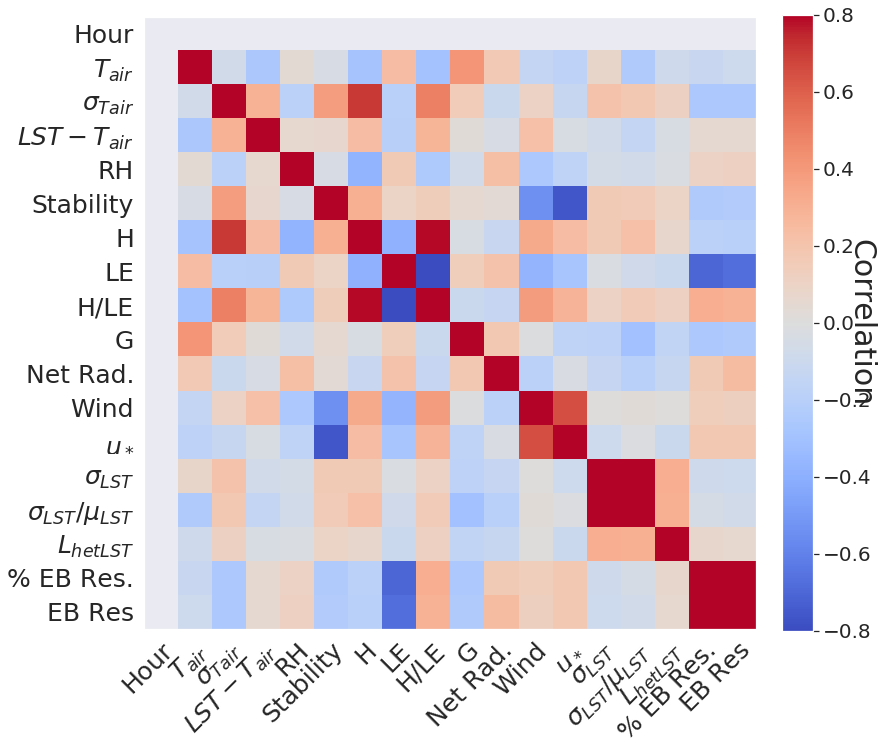

In [279]:
fig, ax = plt.subplots(figsize=(12,12))
#datacm[np.abs(datacm)>=.9999]=float('nan')
im = ax.imshow(datacm,cmap='coolwarm',vmin=-.8,vmax=.8)
#im = ax.imshow(np.abs(datacm),cmap='jet',vmin=0,vmax=1)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Correlation', rotation=270,fontsize=30)
cbar.ax.tick_params(labelsize=20)
plt.grid(False)
ax.set_yticks(np.arange(len(vars_cm)))
ax.set_yticklabels(vars_nm,fontsize=25)
ax.set_xticks(np.arange(len(vars_cm)))
ax.set_xticklabels(vars_nm,fontsize=25)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
     rotation_mode="anchor")
print()

In [334]:
#### CORRELATION MATRIX ####
vars_cm=['HOD','TA','T_SONIC_SIGMA','DELT','RH','logZL','H','LE','BOWEN','G','NETRAD','WS','USTAR','LST_1_STD','COV','LST_1_CL20','EBp','EB']
cms_std=np.zeros((len(sites),len(vars_cm)))
cms_ebp=np.zeros((len(sites),len(vars_cm)))
cms_cov=np.zeros((len(sites),len(vars_cm)))
cms_tssh=np.zeros((len(sites),len(vars_cm)))
all_cms={}
i=0
for site in sites:
    print(site)
    #vars_cm=['CD','COV','T_SONIC_SIGMA','H2O','DOY','DELT','H','LE','G','TA','WS','logZL','ZL','NETRAD','USTAR','ANGLE','BOWEN','LST_1_STD','LST_1_CL20','LST_1_MEAN','GRAD','EBp','EB']
    bowen=fp1['H'][:]/fp1['LE'][:]
    m=~np.isnan(alph1)
    m=m&(fp1['ZL'][:]<0)
    m=m&~np.isnan(bowen)
    m=m&(fp1['NETRAD'][:]>250)
    m=m&(fp1['qH2O'][:]==0)
    m=m&(fpsites==site)
    datacm=np.zeros((len(vars_cm),len(vars_cm)))
    for v in range(len(vars_cm)):
        var1=vars_cm[v]
        if var1 == 'ANGLE':
            dvar1=alph1[m]
        elif var1=='TSSH':
            dvar1=fp1['T_SONIC_SIGMA'][m]/fp1['H'][m]
        elif var1=='COV':
            dvar1=fp1['LST_1_STD'][m]/(fp1['LST_1_MEAN'][m]-273)
        elif var1 == 'BOWEN':
            dvar1=bowen[m]
        elif var1 == 'GRAD':
            dvar1=grad[m]
        elif var1 == 'logZL':
            dvar1=np.log(-fp1['ZL'][m])
        elif var1 == 'EBp':
            dvar1=getEB(fp1)[1][m]
        elif var1 == 'EB':
            dvar1=getEB(fp1)[0][m]
        elif var1 == 'DOY':
            dvar1=doy[m]
        elif var1 == 'DELT':
            dvar1=fp1['LST_1_MEAN'][m]-(fp1['TA'][m]+273)
        elif var1 == 'HOD':
            dvar1=hod[m]
        else:
            dvar1=fp1[var1][m]
        for v2 in range(len(vars_cm)):
            var2=vars_cm[v2]
            if var2 == 'ANGLE':
                dvar2=alph1[m]
            elif var2=='COV':
                dvar2=fp1['LST_1_STD'][m]/(fp1['LST_1_MEAN'][m]-273)
            elif var2 == 'BOWEN':
                dvar2=bowen[m]
            elif var2 == 'GRAD':
                dvar2=grad[m]
            elif var2 == 'logZL':
                dvar2=np.log(-fp1['ZL'][m])
            elif var2== 'EBp':
                dvar2=getEB(fp1)[1][m]
            elif var2 == 'EB':
                dvar2=getEB(fp1)[0][m]
            elif var2 == 'DOY':
                dvar2=doy[m]
            elif var2=='TSSH':
                dvar2=fp1['T_SONIC_SIGMA'][m]/fp1['H'][m]
            elif var2 == 'DELT':
                dvar2=fp1['LST_1_MEAN'][m]-(fp1['TA'][m]+273)
            elif var2 == 'HOD':
                dvar2=hod[m]
            else:
                dvar2=fp1[var2][m]
            datacm[v,v2]=stats.spearmanr(dvar1,dvar2)[0]
            if var1=='EBp':
                cms_ebp[i,v2]=datacm[v,v2]
            if var1=='LST_1_STD':
                cms_std[i,v2]=datacm[v,v2]
            if var1=='COV':
                cms_cov[i,v2]=datacm[v,v2]
            if var1=='TSSH':
                cms_tssh[i,v2]=datacm[v,v2]
    #fig, ax = plt.subplots(figsize=(8,9))
    #im = ax.imshow(datacm,cmap='bwr',vmin=-1,vmax=1)
    #im = ax.imshow(np.abs(datacm),cmap='jet',vmin=0,vmax=1)
    #plt.colorbar(im)
    #plt.grid(False)
    #ax.set_yticks(np.arange(len(vars_cm)))
    #ax.set_yticklabels(vars_cm)
    #ax.set_xticks(np.arange(len(vars_cm)))
    #ax.set_xticklabels(vars_cm)
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #     rotation_mode="anchor")
    #plt.title(site)
    all_cms[site]=datacm.copy()
    i=i+1

b'ABBY'


/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


b'BART'
b'BLAN'
b'CLBJ'
b'CPER'
b'DCFS'
b'DELA'
b'DSNY'
b'GRSM'
b'HARV'
b'JERC'
b'JORN'
b'KONA'
b'KONZ'
b'LENO'
b'MLBS'
b'MOAB'
b'NIWO'
b'NOGP'
b'OAES'
b'ONAQ'
b'ORNL'
b'OSBS'
b'RMNP'
b'SCBI'
b'SERC'
b'SJER'
b'SOAP'
b'SRER'
b'STEI'
b'STER'
b'TALL'
b'TEAK'
b'TREE'
b'UKFS'
b'UNDE'
b'WOOD'
b'WREF'
b'YELL'


In [320]:
a=fp1['LST_1_CL20'][:]

In [321]:
np.sum(np.isnan(a))/len(a)

5.1691607867462715e-05

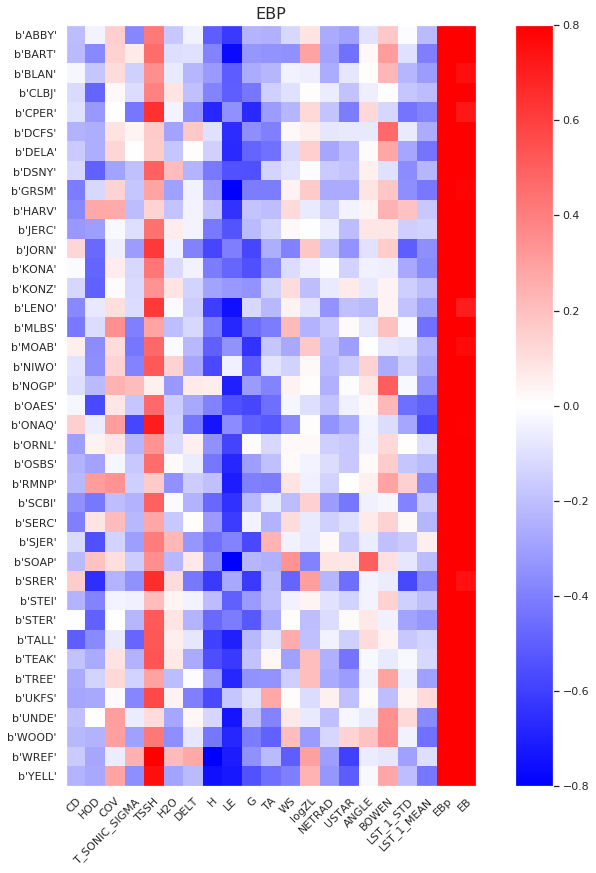

In [322]:
fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(cms_ebp,cmap='bwr',vmin=-.8,vmax=.8)
#im = ax.imshow(cms_ebp,cmap='jet')
plt.colorbar(im)
plt.grid(False)
ax.set_yticks(np.arange(len(sites)))
ax.set_yticklabels(sites)
ax.set_xticks(np.arange(len(vars_cm)))
ax.set_xticklabels(vars_cm)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
     rotation_mode="anchor")
plt.title('EBP',fontsize=16)
i=i+1

Text(0, 0.5, 'Correlation')

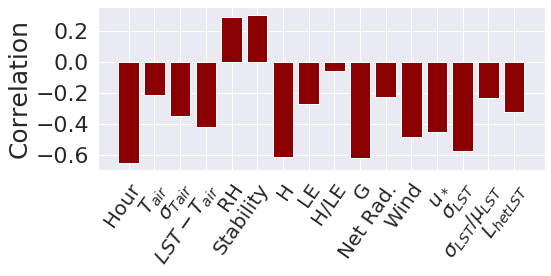

In [345]:
fig,ax=plt.subplots(figsize=(8,3))
vars_nm2=[]
cms_ebp2=[]
for i in range(len(vars_nm)):
    if 'EB' in vars_nm[i]:
        continue
    else:
        vars_nm2.append(vars_nm[i])
        cms_ebp2.append(cms_ebp[-11,i])
plt.bar(vars_nm2,cms_ebp2,color='darkred')
plt.xticks(rotation=55,fontsize=20)
plt.setp(ax.get_xticklabels(), ha="right",
         rotation_mode="anchor")
plt.yticks(fontsize=22)
#plt.title('hello')
plt.ylabel('Correlation',fontsize=25)

Text(0.5, 1.0, 'hello')

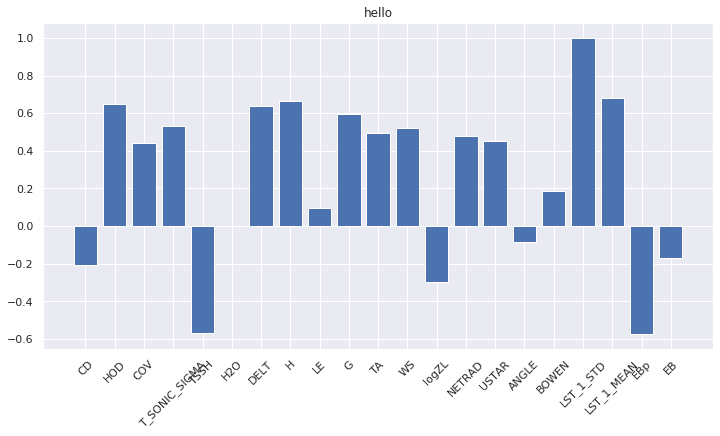

In [331]:
plt.figure(figsize=(12,6))
plt.bar(vars_cm,cms_std[-11,:])
plt.xticks(rotation=45)
plt.title('hello')

Text(0.5, 1.0, 'hello')

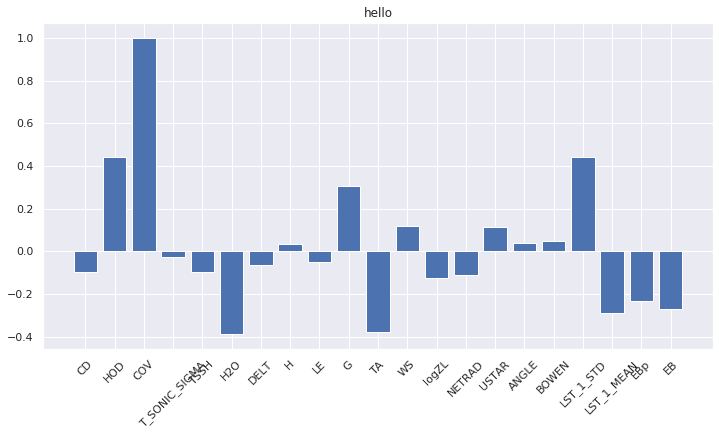

In [332]:
plt.figure(figsize=(12,6))
plt.bar(vars_cm,cms_cov[-11,:])
plt.xticks(rotation=45)
plt.title('hello')

Text(0.5, 1.0, 'hello')

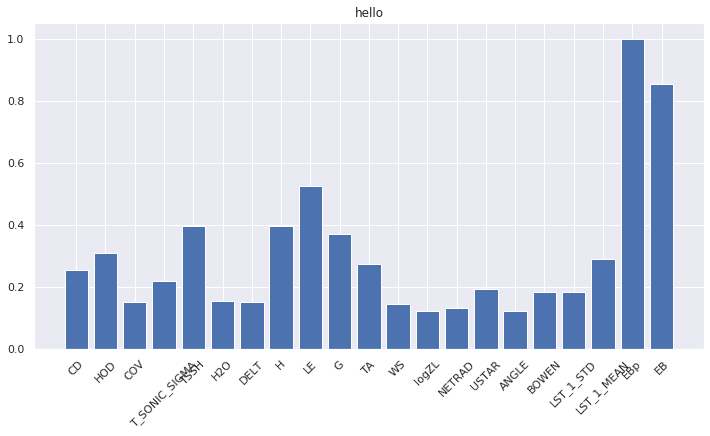

In [238]:
plt.figure(figsize=(12,6))
plt.bar(vars_cm,np.mean(np.abs(cms_ebp),axis=0))
plt.xticks(rotation=45)
plt.title('hello')

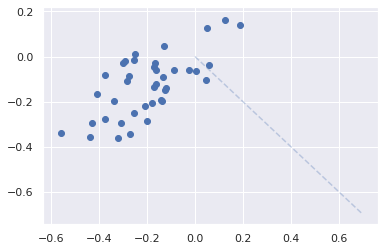

In [239]:
plt.scatter(cms_ebp[:,3],cms_ebp[:,6])
plt.plot([0,.7],[0,-.7],'--',alpha=.3)

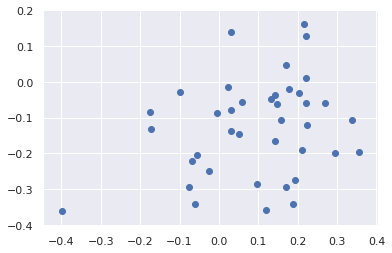

In [240]:
plt.scatter(cms_ebp[:,2],cms_ebp[:,6])

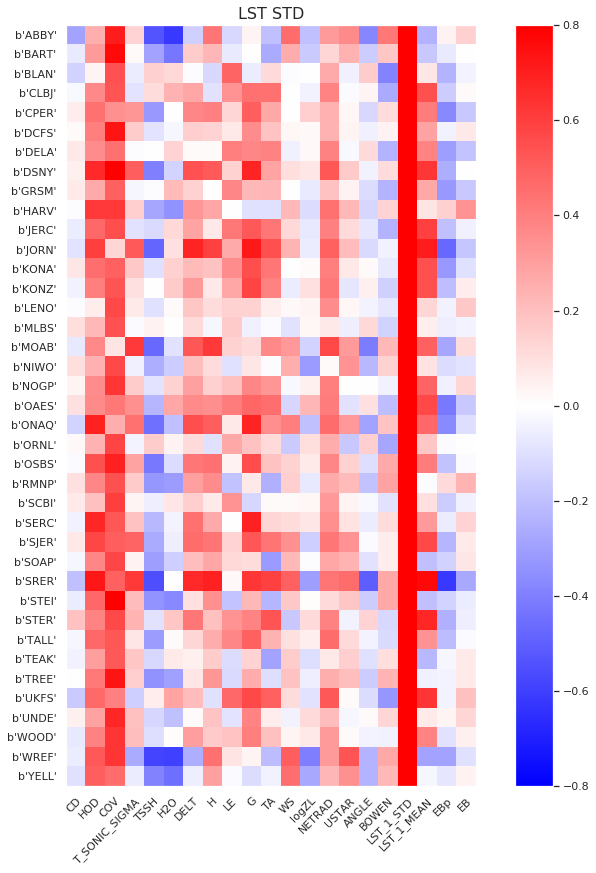

In [241]:
fig, ax = plt.subplots(figsize=(14,14))
#im = ax.imshow(datacm,cmap='bwr',vmin=-1,vmax=1)
#im = ax.imshow((cms_std),cmap='jet',vmin=-1,vmax=1)
im = ax.imshow(cms_std,cmap='bwr',vmin=-.8,vmax=.8)
plt.colorbar(im)
plt.grid(False)
ax.set_yticks(np.arange(len(sites)))
ax.set_yticklabels(sites)
ax.set_xticks(np.arange(len(vars_cm)))
ax.set_xticklabels(vars_cm)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
     rotation_mode="anchor")
plt.title('LST STD',fontsize=16)
i=i+1

Text(0.5, 1.0, 'hello')

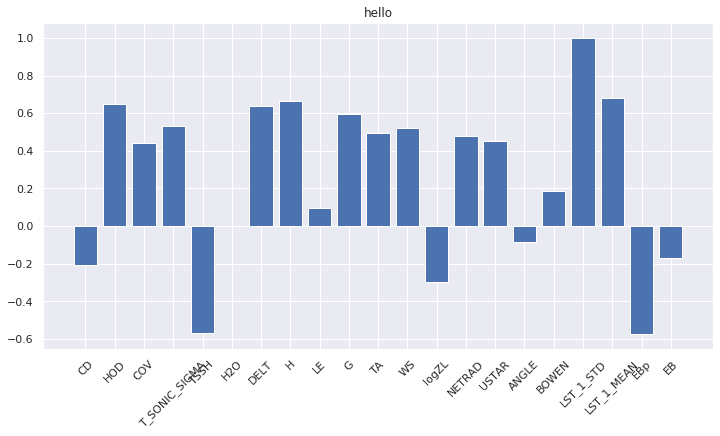

In [330]:
plt.figure(figsize=(12,6))
plt.bar(vars_cm,cms_std[-11,:])
plt.xticks(rotation=45)
plt.title('hello')

Text(0.5, 1.0, 'hello')

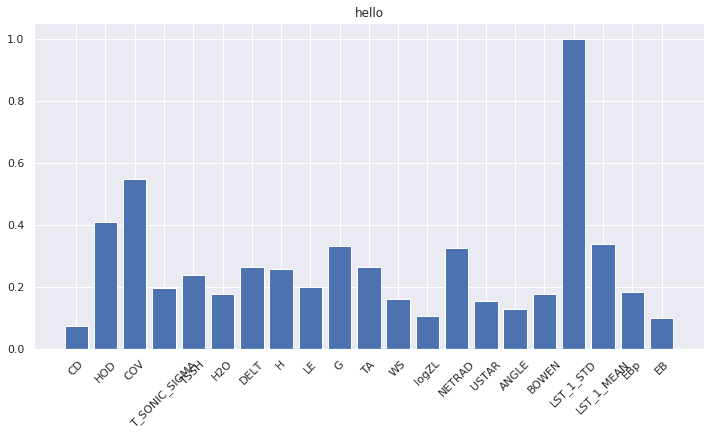

In [243]:
plt.figure(figsize=(12,6))
plt.bar(vars_cm,np.mean(np.abs(cms_std),axis=0))
plt.xticks(rotation=45)
plt.title('hello')

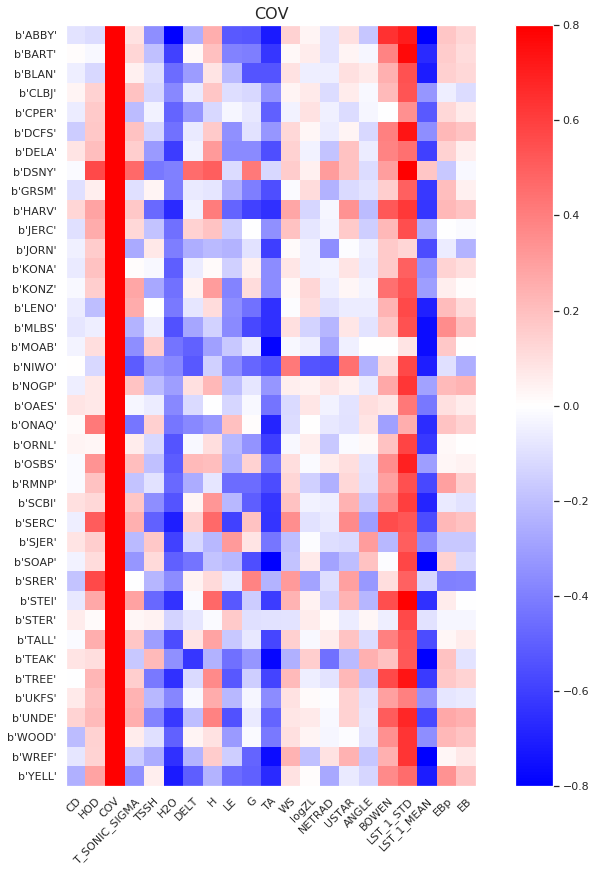

In [244]:
fig, ax = plt.subplots(figsize=(14,14))
#im = ax.imshow(datacm,cmap='bwr',vmin=-1,vmax=1)
#im = ax.imshow(cms_cov,cmap='jet')
im = ax.imshow(cms_cov,cmap='bwr',vmin=-.8,vmax=.8)
plt.colorbar(im)
plt.grid(False)
ax.set_yticks(np.arange(len(sites)))
ax.set_yticklabels(sites)
ax.set_xticks(np.arange(len(vars_cm)))
ax.set_xticklabels(vars_cm)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
     rotation_mode="anchor")
plt.title('COV',fontsize=16)
i=i+1

Text(0.5, 1.0, 'hello')

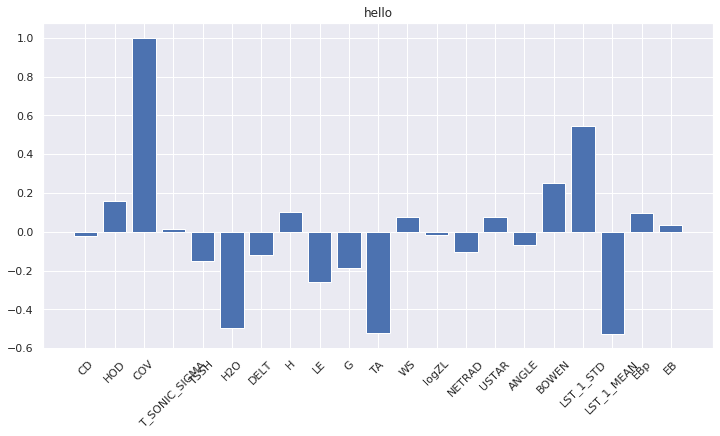

In [245]:
plt.figure(figsize=(12,6))
plt.bar(vars_cm,np.mean(cms_cov,axis=0))
plt.xticks(rotation=45)
plt.title('hello')

Text(0.5, 1.0, 'hello')

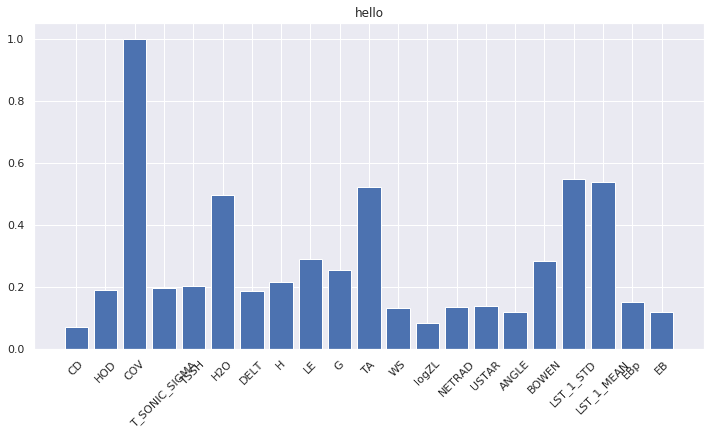

In [246]:
plt.figure(figsize=(12,6))
plt.bar(vars_cm,np.mean(np.abs(cms_cov),axis=0))
plt.xticks(rotation=45)
plt.title('hello')

(array([1., 0., 2., 1., 4., 4., 7., 8., 6., 6.]),
 array([-0.38920025, -0.32536025, -0.26152025, -0.19768025, -0.13384025,
        -0.07000024, -0.00616024,  0.05767976,  0.12151976,  0.18535976,
         0.24919976]),
 <a list of 10 Patch objects>)

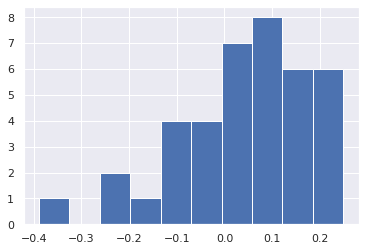

In [247]:
plt.hist(cms_cov[:,-1])

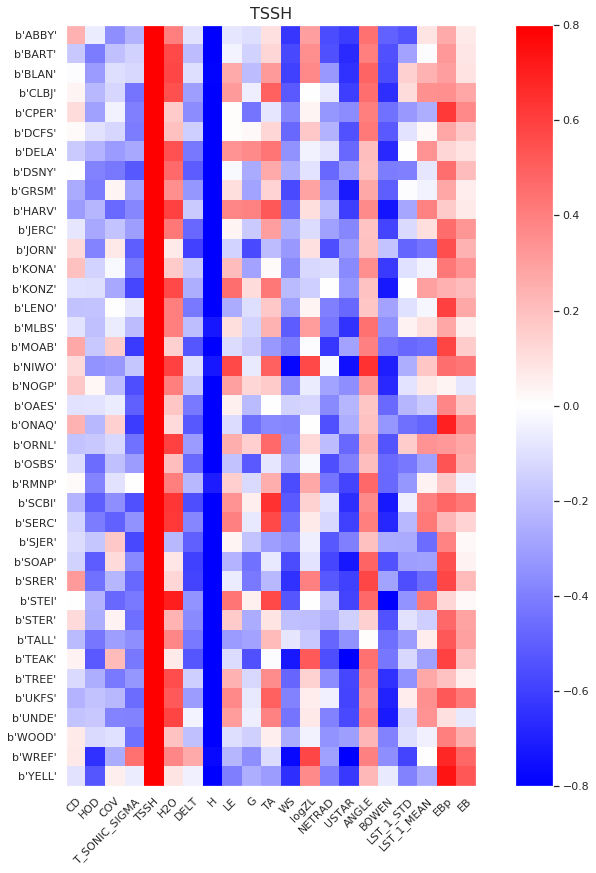

In [248]:
fig, ax = plt.subplots(figsize=(14,14))
#im = ax.imshow(datacm,cmap='bwr',vmin=-1,vmax=1)
#im = ax.imshow(cms_cov,cmap='jet')
im = ax.imshow(cms_tssh,cmap='bwr',vmin=-.8,vmax=.8)
plt.colorbar(im)
plt.grid(False)
ax.set_yticks(np.arange(len(sites)))
ax.set_yticklabels(sites)
ax.set_xticks(np.arange(len(vars_cm)))
ax.set_xticklabels(vars_cm)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
     rotation_mode="anchor")
plt.title('TSSH',fontsize=16)
i=i+1

Text(0.5, 1.0, 'hello')

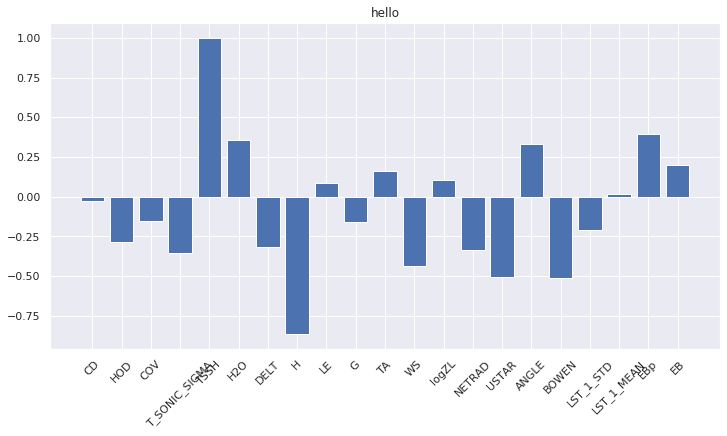

In [249]:
plt.figure(figsize=(12,6))
plt.bar(vars_cm,np.mean(cms_tssh,axis=0))
plt.xticks(rotation=45)
plt.title('hello')

Text(0.5, 1.0, 'hello')

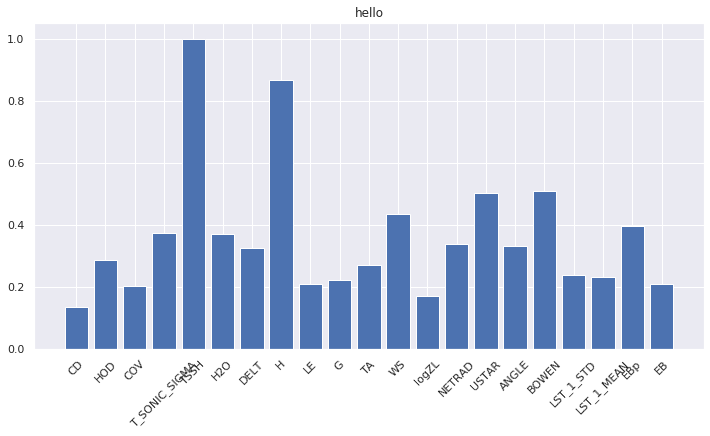

In [250]:
plt.figure(figsize=(12,6))
plt.bar(vars_cm,np.mean(np.abs(cms_tssh),axis=0))
plt.xticks(rotation=45)
plt.title('hello')

(array([4., 4., 3., 4., 5., 5., 3., 5., 3., 3.]),
 array([-0.2692585 , -0.18767713, -0.10609575, -0.02451438,  0.057067  ,
         0.13864837,  0.22022974,  0.30181112,  0.38339249,  0.46497386,
         0.54655524]),
 <a list of 10 Patch objects>)

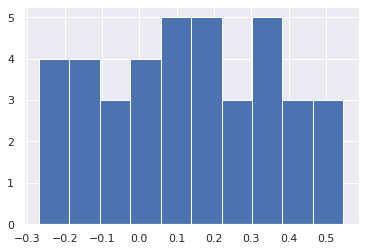

(array([1., 1., 0., 2., 7., 9., 2., 6., 8., 3.]),
 array([-0.38415148, -0.31593486, -0.24771824, -0.17950162, -0.111285  ,
        -0.04306838,  0.02514824,  0.09336485,  0.16158147,  0.22979809,
         0.29801471]),
 <a list of 10 Patch objects>)

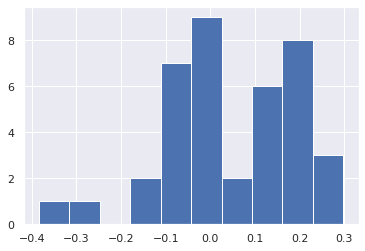

(-0.7, 0.4)

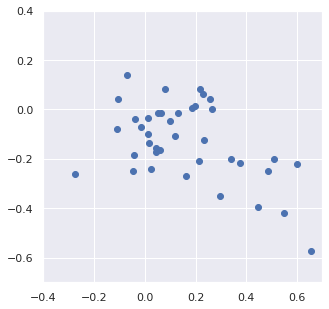

In [483]:
plt.figure(figsize=(5,5))
plt.scatter(cms_std[:,1],cms_std[:,-2])
plt.xlim(-.4,.7)
plt.ylim(-.7,.4)

In [511]:
vars_cm=['CD','T_SONIC_SIGMA','H2O','DOY','DELT','H','LE','G','TA','WS','logZL','ZL','NETRAD','USTAR','ANGLE','BOWEN','LST_1_STD','LST_1_CL20','LST_1_MEAN','GRAD','EBp','EB']


(-0.6, 0.2)

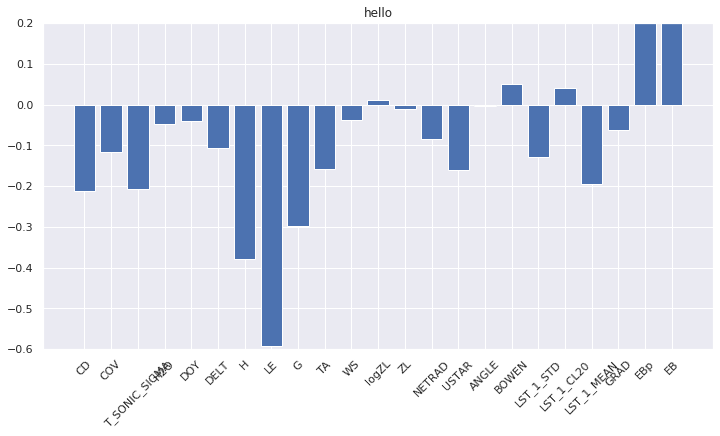

In [518]:
plt.figure(figsize=(12,6))
plt.bar(vars_cm,np.mean(cms_ebp,axis=0))
plt.xticks(rotation=45)
plt.title('hello')
plt.ylim(-.6,.2)

(-0.2, 0.35)

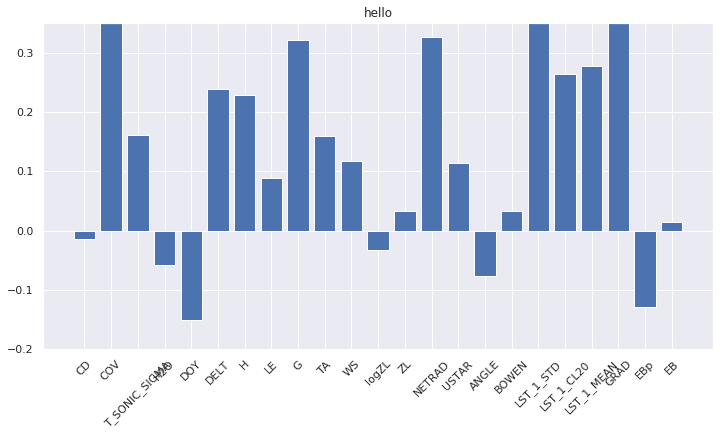

In [519]:
plt.figure(figsize=(12,6))
plt.bar(vars_cm,np.mean(cms_std,axis=0))
plt.xticks(rotation=45)
plt.title('hello')
plt.ylim(-.2,.35)

In [435]:
fp1.close()

In [506]:
np.mean(fp1['qH2O'][:])

0.28883547422742584